[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://githubtocolab.com/comp-neural-circuits/plasticity-workshop/blob/dev/stdp.ipynb)

# Spike timing dependent plasticity (STDP) rules

# Hello there!

Welcome to the second day of the plasticity tutorial! Today is all about *timing*!

In this tutorial you will learn:
- how the temporal order of pre- and postsynaptic spikes influences the change in the synaptic connection and how different parameters shape the **pairwise STDP rule**;
- how to generate **spike trains** and how to **keep track** of pre- and postsynaptic spikes over time, by using specific functions.
- how to generalise the points above to the **triplet STDP rule**.
- how the pairwise and the triplet STDP rules fit some **experimental data**. Do you have any guess on which one matches better the data? :)  
- how to implement the **inhibitory plasticity**, and how it influences the postsynaptic firing rate and the membrane currents.

So, let's start! Please, just run the two cells below (i.e. Initialization and Utility functions) to initialize and implement the figure setup.

## Initialization

In [1]:
!pip install numpy scipy matplotlib ipywidgets scikit-learn --quiet
import numpy as np
import scipy.linalg as lin
from numpy.random import default_rng
rng = default_rng()
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
plt.style.use("https://github.com/comp-neural-circuits/plasticity-workshop/raw/dev/plots_style.txt")

## Utility functions

In [2]:
def pairSTDP_plot(A_plus, A_minus, tau_plus, tau_minus):
    '''
    Generates a plot for the pairwise STDP rule, which shows the synaptic change DeltaW 
              over the time difference Delta_t (t_post - t_pre)
    
    Parameters:
    A_plus     (number) : maximum amount of potentiation (LTP)
    A_minus    (number) : maximum amount of depression (LTD)
    tau_plus   (number) : LTP time constant [ms]
    tau_minus  (number) : LTD time constant [ms]
    
    Returns:
    A plot for the pairwise STDP rule
    '''    
    # Calculate the synaptic change via the specific function
    Delta_t, DeltaW = DeltaW_pairSTDP(A_plus, A_minus, tau_plus, tau_minus)
    
    # Plotting
    plt.figure(figsize=(8,6))
    plt.plot([Delta_t[0], Delta_t[-1]], [0, 0], 'k', linestyle=':')
    plt.plot([0, 0], [-0.1, 0.1], 'k', linestyle=':')

    plt.plot(Delta_t[Delta_t <= 0], DeltaW[Delta_t <= 0], 'r')
    plt.plot(Delta_t[Delta_t > 0], DeltaW[Delta_t >= 0], 'b')

    plt.xlabel(r'$\Delta t=$ t$_{\mathrm{post}}$ - t$_{\mathrm{pre}}$ (ms)',fontsize=16)
    plt.ylabel(r'$\Delta $W')
    plt.title('The Pairwise STDP rule', fontsize=18, fontweight='bold')
    plt.show()
    
def tripletSTDP_plot(A_plus, A_minus, tau_plus, tau_minus, tau_y, Delta_t2):
    '''
    Generates a plot for the pairwise STDP rule, which shows the synaptic change DeltaW 
              over the time difference Delta_t1 (t_post - t_pre), for a given value of 
              the time difference Delta_t2 (t_post - t'_post)
              
    Parameters:
    A_plus     (number) : maximum amount of potentiation (LTP)
    A_minus    (number) : maximum amount of depression (LTD)
    tau_plus   (number) : LTP time constant [ms]
    tau_minus  (number) : LTD time constant [ms]
    tau_y      (number) : second LTP time constant [ms]
    Delta_t2   (number) : time differences between the postsynaptic spikes [ms]
    
    Returns:
    A plot for the triplet STDP rule
    '''
    
    # Calculate the synaptic change via the specific function
    Delta_t1, DeltaW = DeltaW_tripSTDP(A_plus, A_minus, tau_plus, tau_minus, tau_y, Delta_t2)
    
    # Plotting
    plt.figure(figsize=(8,6))
    plt.plot([Delta_t1[0], Delta_t1[-1]], [0, 0], 'k', linestyle=':')
    plt.plot([0, 0], [-0.1, 0.1], 'k', linestyle=':')

    plt.plot(Delta_t1[Delta_t1 <= 0], DeltaW[Delta_t1 <= 0], 'r')
    plt.plot(Delta_t1[Delta_t1 > 0], DeltaW[Delta_t1 > 0], 'b')

    plt.xlabel(r'$\Delta t=$ t$_{\mathrm{post}}$ - t$_{\mathrm{pre}}$ (ms)',fontsize = 16)
    plt.ylabel(r'$\Delta $W (%)')
    plt.title('The triplet STDP rule', fontsize=18, fontweight='bold')
    plt.show()
    
    
def pair_track_plot(t_range,pre_spike,r1,post_spike,o1,w):
    '''
    Generates plots for the pre- and postsynaptic spike trains and detector traces over time,
              under the pairwise STDP rule. 
              A plot showing the synaptic weight over time is also shown.
              
    Parameters:
    t_range    (1D numpy array) : time interval [s]
    pre_spike  (1D numpy array) : presynaptic spike train over time (binary array with value 1
                                  at time t if there was a spike a time t, 0 at time t otherwise).
    r1         (1D numpy array) : presynaptic detector trace over time 
    post_spike (1D numpy array) : postsynaptic spike train over time (analougous to the presyn. spike train)
    o1         (1D numpy array) : postsynaptic detector trace over time 
    w:         (1D numpy array) : synaptic weight over time
    
    Returns:
    Five subplots described above.
    '''
    
    # Plotting
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5,1, figsize=(8,12));
    # Raster plot
    if pre_spike.sum() > 0.:
        t_sp = t_range[pre_spike > 0.5]  # spike times
        ax1.plot(1000*t_sp, np.ones(len(t_sp)), '|',color="dimgrey", ms=50, markeredgewidth=2)
    ax1.set_yticklabels([])
    ax1.set_xlabel("time (ms)", fontsize=12);
    ax1.set_ylabel("spike train", fontsize=12);
    ax1.set_title("Presynaptic spike train", fontsize=14);
    # Presynaptic detector trace
    ax2.plot(1000*t_range,r1,color="dimgrey");
    ax2.set_xlabel("time (ms) ", fontsize=12);
    ax2.set_ylabel("$r_1(t)$", fontsize=12);
    ax2.set_title("Presynaptic detector trace", fontsize=14);
    # Raster plot
    if post_spike.sum() > 0.:
        t_sp = t_range[post_spike > 0.5]  # spike times
        ax3.plot(1000*t_sp, np.ones(len(t_sp)), '|',color="black", ms=50, markeredgewidth=2)
    ax3.set_yticklabels([])
    ax3.set_xlabel("time (ms) ", fontsize=12);
    ax3.set_ylabel('spike train', fontsize=12);
    ax3.set_title("Postsynaptic spike train", fontsize=14);
    # Postsynaptic detector trace
    ax4.plot(1000*t_range,o1,color="black");
    ax4.set_xlabel("time (ms) ", fontsize=12);
    ax4.set_ylabel('$o_1(t)$', fontsize=12);
    ax4.set_title("Postsynaptic detector trace", fontsize=14);
    # Synaptic weight
    ax5.plot(1000*t_range,w,'b');
    ax5.set_xlabel("time (ms) ", fontsize=12);
    ax5.set_ylabel('$W(t)$', fontsize=14);
    ax5.set_title("Synaptic weight", fontsize=12);
    ax1.get_shared_x_axes().join(ax1, ax2, ax3, ax4, ax5)
    
def trip_track_plot(t_range,pre_spike,r1,post_spike,o1,o2,w):
    '''
    Generates plots for the pre- and postsynaptic spike trains and detector traces over time,
              under the triplet STDP rule. 
              A plot showing the synaptic weight over time is also shown.
              Note that this function is analougous to the previous pair_track_plot, 
              with the additon of the second postsynaptic detector.
              
    Parameters:
    t_range    (1D numpy array) : time interval [ms]
    pre_spike  (1D numpy array) : presynaptic spike train over time (binary array with value 1
                                  at time t if there was a spike a time t, 0 at time t otherwise).
    r1         (1D numpy array) : presynaptic detector trace over time 
    post_spike (1D numpy array) : postsynaptic spike train over time (analougous to the presyn. spike train)
    o1         (1D numpy array) : postsynaptic detector trace over time 
    o2         (1D numpy array) : second postsynaptic detector trace over time 
    w:         (1D numpy array) : synaptic weight over time
    
    Returns:
    Six subplots described above.
    '''
  
    # Plotting
    fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6,1, figsize=(8,12)); #gridspec_kw={'height_ratios': [3, 1]})
    # Raster plot
    if pre_spike.sum() > 0.:
        t_sp = t_range[pre_spike > 0.5]  # spike times
        ax1.plot(1000*t_sp, np.ones(len(t_sp)), '|',color="dimgrey", ms=50, markeredgewidth=2)
    ax1.set_yticklabels([])
    ax1.set_xlabel("time (ms)", fontsize=12);
    ax1.set_ylabel("spike train", fontsize=12);
    ax1.set_title("Presynaptic spike train", fontsize=14);
    # Presynaptic detector trace
    ax2.plot(1000*t_range,r1,color="dimgrey");
    ax2.set_xlabel("time (ms) ", fontsize=12);
    ax2.set_ylabel("$r_1(t)$", fontsize=12);
    ax2.set_title("Presynaptic detector trace", fontsize=14);
    # Raster plot
    if post_spike.sum() > 0.:
        t_sp = t_range[post_spike > 0.5]  # spike times
        ax3.plot(1000*t_sp, np.ones(len(t_sp)), '|',color="black", ms=50, markeredgewidth=2)
    ax3.set_yticklabels([])    
    ax3.set_xlabel("time (ms) ", fontsize=12);
    ax3.set_ylabel('spike train', fontsize=12);
    ax3.set_title("Postsynaptic spike train", fontsize=14);
    # Postsynaptic detector trace
    ax4.plot(1000*t_range,o1,color="black");
    ax4.set_xlabel("time (ms) ", fontsize=12);
    ax4.set_ylabel('$o_1(t)$', fontsize=12);
    ax4.set_title("Postsynaptic detector trace", fontsize=14);
    # Second postsynaptic detector trace
    ax5.plot(1000*t_range,o2,color="black");
    ax5.set_xlabel("time (ms) ", fontsize=12);
    ax5.set_ylabel('o_2(t)', fontsize=12);
    ax5.set_title("Second postsynaptic spike train", fontsize=14);
    # Synaptic weight
    ax6.plot(1000*t_range,w,'b');
    ax6.set_xlabel("time (ms) ", fontsize=12);
    ax6.set_ylabel('$W(t)$', fontsize=14);
    ax6.set_title("Synaptic weight", fontsize=12);
    ax1.get_shared_x_axes().join(ax1, ax2, ax3, ax4, ax5, ax6)
    
def plot_over_frequency(rho_vec,DeltaW,DeltaW_rev):
    '''
    Generates a plot for the synaptic change as a function of the frequency of pairs of presynaptic and postsynaptic spikes
    
    Parameters: 
    rho_vec  (1D numpy array) : frequency values of pairs of presynaptic and postsynaptic spikes
    DeltaW   (1D numpy array) : synaptic change(in %) as a function of the frequency.
    
    Returns:
    Two plots for the weight change in a pairing protocol as a function of the frequency:
    the first one for Delta_t >0 (pre-post pairing)
    the second one for Delta_t <0 (post-pre pairing)
    '''
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4)); 
    ax1.set_ylim([-0.6, 1])
    ax1.plot(rho_vec,DeltaW,color="blue",label="$\Delta t = 10$ ms")
    ax1.legend(fontsize=10)
    ax1.set_xlabel(r'$\rho$(Hz)',fontsize=12)
    ax1.set_ylabel(r'$\Delta $W',fontsize=12)
    ax1.set_title(r'Weight change over frequency', fontsize=14)
    ax2.set_ylim([-0.6, 1])
    ax2.plot(rho_vec,DeltaW_rev,color="orange",label="$\Delta t = -10$ ms")
    ax2.set_xlabel(r'$\rho$(Hz)',fontsize=12)
    ax2.set_ylabel(r'$\Delta $W',fontsize=12)
    ax2.legend(fontsize=10)
    ax1.get_shared_x_axes().join(ax1, ax2)
    
    
def inhSTDP_plot(eta, rho, tau):
    """    
    Generates a plot for the inhibitory plasticity rule
    
    Parameters:
    eta : 
    rho : 
    tau : 
    
    Returns:
    A plot for the inhibitory STDP rule
    """
    # Calculate the synaptic change via the specific function
    Delta_t, DeltaW = DeltaW_inhSTDP(eta, rho, tau)
    
    # Plotting
    plt.figure(figsize=(8,5))
    plt.plot([Delta_t[0], Delta_t[-1]], [0, 0], 'k', linestyle=':')
    plt.plot([0, 0], [-80, 100], 'k', linestyle=':')
    plt.plot(Delta_t, DeltaW, 'r')
    plt.xlabel(r'$\Delta t=$ t$_{\mathrm{post}}$ - t$_{\mathrm{pre}}$ (ms)',fontsize=16)
    plt.ylabel(r'$\Delta $W (%)',fontsize=16)
    plt.title('The inhibitory STDP rule', fontsize=18, fontweight='bold')
    plt.show()

    
def inh_analysis_plot(num_small_intervals,post_spike,save_inh_weights, duration,Exkeep,Inkeep):
    '''
    
    ....
    
    
    '''
    post_rate = np.zeros(num_small_intervals)
    inh_weights = np.zeros(num_small_intervals)
    for i in range(num_small_intervals):
        post_rate[i] = np.sum(post_spike[i*duration:(i+1)*duration])/ duration * 1000
        inh_weights[i] = np.mean(save_inh_weights[i*duration:(i+1)*duration])
    Exkeep0 = Exkeep[0:int(duration/10)]
    Inkeep0 = Inkeep[0:int(duration/10)]
    Exkeep1 = Exkeep[int(duration*(num_small_intervals-1/10)):duration*num_small_intervals]
    Inkeep1 = Inkeep[int(duration*(num_small_intervals-1/10)):duration*num_small_intervals]    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(8,12));
    ax1.plot(range(num_small_intervals),post_rate)
    ax1.set_xlabel("time (s)", fontsize=12);
    ax1.set_ylabel("Firing rate [Hz]", fontsize=12);
    ax1.set_title("Postsynaptic firing rate", fontsize=14);
    ax2.plot(range(num_small_intervals),inh_weights)
    ax2.set_xlabel("time (s) ", fontsize=12);
    ax2.set_ylabel("Mean inhibitory weights", fontsize=12);
    ax2.set_title("Inhibitory weights", fontsize=14);
    ax3.plot(range(int(duration/10)), Exkeep0/100,'r',linewidth=3)
    ax3.plot(range(int(duration/10)), Inkeep0/100, 'g')
    ax3.plot(range(int(duration/10)), (Inkeep0 + Exkeep0)/100, 'k')
    ax3.set_xlabel("time (ms) ", fontsize=12);
    ax3.set_ylabel('Currents', fontsize=12);
    ax3.set_title("Currents before plasticity", fontsize=14);
    ax4.plot(range(int(duration/10)), Exkeep1/100, 'r')
    ax4.plot(range(int(duration/10)), Inkeep1/100, 'g')
    ax4.plot(range(int(duration/10)), (Inkeep1 + Exkeep1)/100, 'k')
    ax4.set_xlabel("time (ms) ", fontsize=12);
    ax4.set_ylabel('Currents', fontsize=12);
    ax4.set_title("Currents after plasticity", fontsize=14);

## 1. The pair-based STDP rule

#### Coding Exercise 1: the pair-based STDP function

Let's begin by visualizing the **pairwise spike timing dependent plasticity (STDP) rule**. 
Recall that, under this rule, the synaptic weight increases (*long-term potentiation*) if a postsynaptic spike follows a presynaptic spike within a short time window, whereas the synaptic weight decreases (*long-term depression*) if the opposite occurs: 

$$
\Delta W (\Delta t) = \begin{cases}
A_+e^{-\Delta t/\tau_+} & \text{if } \Delta t\geq 0 \\
-A_-e^{\Delta t/\tau_-} & \text{if } \Delta t<0
\end{cases}
$$

where $A_+, A_-$ are positive constants. 

In the following exercise, you will fill a function script for the pairwise STDP rule.
Consider the time difference $\Delta t = t_{post} - t_{pre}$ between a post- and a presynaptic spike and compute the weight change $\Delta W$ as a function of $\Delta t$.

After plotting and visualising the pair-based STDP rule for some specific values, you can play with the sliders and see how varying the parameters changes the shape of the STDP function (and therefore, how it influences the synaptic weight change).

How do the temporal constants and the amplitude values shape the STDP window? What can you tell about the influence of these parameters on the synaptic change? 

*Bonus question*: what do you think will happen if we replace $A_+$ with $-A_+$ and we replace $-A_-$ with $A_-$?

In [3]:
def DeltaW_pairSTDP(A_plus, A_minus, tau_plus, tau_minus):
    """    
    Implements the pairwise STDP rule and calculates the instantaneous synaptic weight change due to the STDP pairwise rule
    
    Parameters:
    A_plus     (number) : maximum amount of potentiation (LTP)
    A_minus    (number) : maximum amount of depression (LTD)
    tau_plus   (number) : LTP time constant [s]
    tau_minus  (number) : LTD time constant [s]
    
    Returns:
    Delta_t (1D numpy array) : time differences between post- and presynaptic spikes [s]
    DeltaW  (1D numpy array) : synaptic weight change DeltaW due to the pairwise STDP rule over time.
    """
    # Define the array with the time differences between post- and presynaptic spikes
    Delta_t = np.linspace(-200, 200, 50)
    # Initialize the STDP change
    DeltaW = np.zeros(len(Delta_t))
    # Calculate the synaptic change DeltaW for potentiation (LTP)
    DeltaW[Delta_t > 0] = A_plus * np.exp(-Delta_t[Delta_t > 0] / tau_plus)
    # Calculate the synaptic change DeltaW for depression (LTD)
    DeltaW[Delta_t <= 0] = -A_minus * np.exp(Delta_t[Delta_t <= 0] / tau_minus)
    
    return Delta_t, DeltaW

# Plot the pairwise STDP function 
interact(pairSTDP_plot, A_plus = (0.01,0.1,1e-3), A_minus = (0.01,0.1,1e-3), tau_plus = (10,70,0.1), tau_minus  = (10,70,0.1));

interactive(children=(FloatSlider(value=0.055, description='A_plus', max=0.1, min=0.01, step=0.001), FloatSlid…

## 2. Pre- and postsynaptic event detectors and spike trains 

Good job so far! You will now deepen the analysis of the pairwise STDP rule by visualising how the synaptic change is related to two specific spike trains (pre- and post), which are randomly generated under the Poisson distribution. This probabilistic distribution is commonly used for simulating spike trains.

##### Bonus: Poisson spike train 

The next function generates a train of spikes drawn from the Poisson distribution. The output will be an array of binary values: this array will take the value 1 at time *t* if there is a spike at time *t*, 0 otherwise.

You can just run the cell below, however if you have extra time you can check how this is implemented. 

In [4]:
def Poisson_spike_train(discretization_step, t_range, rate, myseed=False):
    """
    Generates a Poisson spike train
    
    Parameters:
    discretization_step   (number) : discretization time step [s]
    t_range       (1D numpy array) : time interval [s]
    rate                  (number) : intensity of the Poisson process [Hz]
    myseed                (number) : random seed. int or boolean

    Returns:
    Poisson_train (1D numpy array) : a spike train of binary values (1 if spike, 0 otherwise)
    """
    # set random seed
    if myseed:
        np.random.seed(seed=myseed)
    else:
        np.random.seed()

    # generate an uniformly distributed random variable (for the ISI = interspike interval)
    unirnd = np.random.rand(len(t_range))

    # generate Poisson train
    # note that we divide by 1000 in the expression below because the time is measured in ms, 
    # whereas the intensity is given in Hz (s^-1)
    poisson_train = 1. * (unirnd < rate * (discretization_step))

    return poisson_train

#### Coding exercise 2: keeping track

In this section, we focus on how the precise timing of a presynaptic (*resp*. postsynaptic) spike induces depression (*resp.* potentiation) in a synaptic connection between two neurons.
A standard way to analyse this phenomenon is to keep track of the pre- and postsynaptic events. We call $r_1(t)$ a detector of presynaptic events and $o_1(t)$ a detector of postsynaptic events. These quantities are abstract variables, that describe quantities that increase after spike arrival: for instance, $r_1(t)$ could describe the amount of glutamate bound to a postsynaptic receptor, whereas $o_1(t)$ could represent the voltage trace of a back-propagating action potential. However, we are interested in their trend related to the spiking activity, rather than what they describe.

- The variable $r_1$ increases whenever there is a presynaptic spike and decreases back to zero otherwise with a time constant of $\tau_+$. 

- The variable $o_1$ increases whenever there is a postsynaptic spike and decreases back to zero otherwise with a time constant of $\tau_-$. 


We can then describe the dynamics for these detectors with the following equations. 

For the presynaptic train:
$$
\frac{dr_1(t)}{dt} = - \frac{r_1(t)}{\tau_+} \text{ and whenever there is a presynaptic spike at time }t^{\text{pre}}\text{, } r_1 \rightarrow r_1 +1
$$

And for the postsynaptic train:
$$
\frac{do_1(t)}{dt} = - \frac{o_1(t)}{\tau_-} \text{ and whenever there is a postsynaptic spike at time }t^{\text{post}}\text{, } o_1 \rightarrow o_1 +1 
$$

These variables allow us to keep track of spikes. In the previous section, we have seen how the synapse changes as a function of the time difference between spikes. It is possible to define the synaptics change $W$ as a function of these detectors.

$$
 W = \begin{cases}
W - o_1(t) A_-, & \text{if } t=t^{\text{pre}} \\
W + r_1(t) A_+,& \text{if } t=t^{\text{post}}
\end{cases}
$$

that is the weight decreases after presynaptic spike by an amount that is proportional to the value of the postsynaptic variable $o_1$, and increases after postsynaptic spike by an amount that is proportional to the value of the presynaptic variable $r_1$.

In the following exercise, you will complete a function that implements this standard procedure. If everything is correct, you will see the correspondence between the spike trains and the detector traces, and how they shape the synaptic connection.

In [5]:
# Keeping track of the detectors
def detectors_pairSTDP(t_range,pre_spike,post_spike,A_plus,A_minus,tau_plus,tau_minus,discretization_step,w0):
    '''
    This function implements a standard way to keep track of the pre- and postsynaptic spike times of two given spike trains,
    under the pair-based STDP rule. 
    It calculates the pre- and postsynaptic detector traces over time, as well as the synaptic weight over time. 

    Parameters:
    t_range    (1D numpy array) : time interval [s]
    pre_spike  (1D numpy array) : presynaptic spike train over time (binary array with value 1
                                  at time t if there was a spike a time t, 0 at time t otherwise).
    post_spike (1D numpy array) : postsynaptic spike train over time (analougous to the presyn. spike train)
    A_plus     (number) : maximum amount of potentiation (LTP)
    A_minus    (number) : maximum amount of depression (LTD)
    tau_plus   (number) : LTP time constant [s]
    tau_minus  (number) : LTD time constant [s]    
    discretization_step(number) : discretization time step [ms]
    w0         (number) : initial synaptic weight 

    Returns:
    r1         (1D numpy array) : presynaptic detector trace over time 
    o1         (1D numpy array) : postsynaptic detector trace over time 
    w:         (1D numpy array) : synaptic weight over time
    '''
    
    # Initialize the synaptic weight
    w = np.ones(len(t_range))
    w[0] = w0
    # Initialize the pre- and postsynaptic event detectors
    r1 = np.zeros(len(t_range))        # presynaptic event detector
    o1 = np.zeros(len(t_range))        # postsynaptic event detector
    for i in range(len(t_range)-1):
        if i==0:
            continue
        w[i+1]=w[i]
        # if there is a pre-synaptic spike
        if pre_spike[i]==1:     
            # Update the presynaptic detector
            r1[i] += 1
            # Update the synaptic weight
            w[i+1] = w[i] - o1[i]*A_minus 
            
        # if there is a post-synaptic spike
        if post_spike[i]==1:    
            # Update the postsynaptic detector
            o1[i] += 1
            # Update the synaptic weight
            w[i+1] = w[i] + r1[i]*A_plus

        # Apply Euler's method to the detector equations
        r1[i+1] = r1[i] - discretization_step * r1[i]/tau_plus
        o1[i+1] = o1[i] - discretization_step * o1[i]/tau_minus
    return r1,o1,w

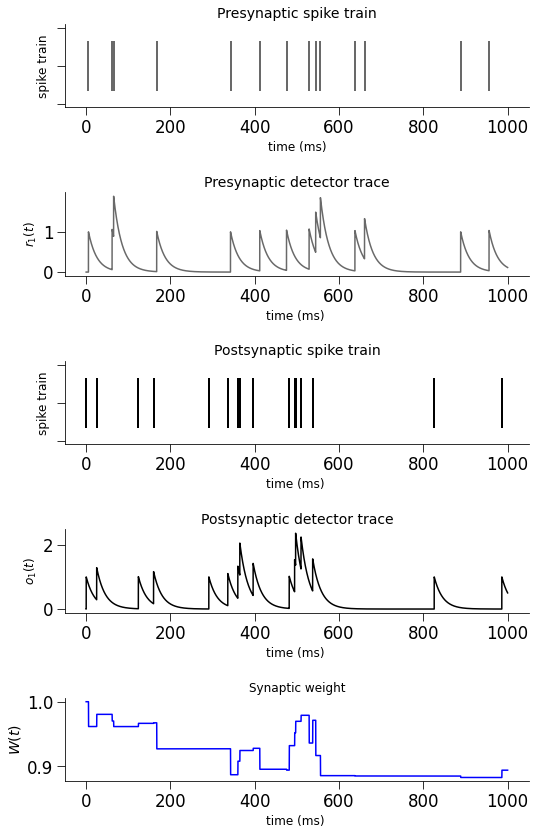

In [6]:
# Define the STDP rule parameters
A_plus = 0.05       # maximum amount of potentiation (LTP)
A_minus = 0.05      # maximum amount of potentiation (LTD)
tau_plus = 20e-3       # LTP time constant [s]
tau_minus = 20e-3      # LTD time constant [s]
discretization_step=1e-4 # discretization time step [s]
t_range=np.arange(0,1,discretization_step)     # time interval [s]

# Generate a presynaptic spike train
pre_spike = Poisson_spike_train(discretization_step, t_range, rate=15, myseed=7)
# Generate a postsynaptic spike train
post_spike = Poisson_spike_train(discretization_step, t_range, rate=15, myseed=1)
# Initialize the synaptic weight
w0 = 1
# Keep track of the pre- and postsynaptic detector traces and the synaptic weight over time 
r1,o1,w = detectors_pairSTDP(t_range,pre_spike,post_spike,A_plus,A_minus,tau_plus,tau_minus,discretization_step,w0)
# Plotting
pair_track_plot(t_range,pre_spike,r1,post_spike,o1,w)

## 3. The triplet STDP rule

Let's now turn to the **triplet spike timing dependent plasticity (STDP) rule**, which uses sets of three spikes to induce *long term potentiation*, and pairs of spikes to induce *long term depression*.

Recall that, under this rule, potentiation depends on the interval $\Delta t_1$ between the pre- and postsynaptic spikes, and on the timing $\Delta t_2$ of the previous postsynaptic spike, whereas *long-term depression* depends only on $\Delta t_1$.

$$
\Delta W (\Delta t) = \begin{cases}
A_+e^{-\Delta t_1/\tau_+}e^{-\Delta t_2/\tau_y} & \text{if } \Delta t_1\geq 0, \Delta t_2\geq 0 \\
-A_-e^{\Delta t/\tau_-} & \text{if } \Delta t_1<0
\end{cases}
$$

where $\Delta t_1 = t_{post} - t_{pre}$ denotes the time difference between a post- and a presynaptic spike and $\Delta t_2 = t_{post} - t'_{post}$ denotes the time difference between two consecutive postpresynaptic spikes.

In the following exercise, you will fill a function script for the triplet STDP rule.
Consider the time difference $\Delta t_1$ between a post- and a presynaptic spike and compute the weight change $\Delta W$ as a function of $\Delta t_1$ for a given value of $\Delta t_2$. Then, you can play again with the interactive plot. This time, you will focus on how varying the time difference $\Delta t_2$ between two postsynaptic spikes changes the shape of the STDP function (and therefore, how it influences the synaptic weight change). Enjoy it!

*Bonus*: in the interactive plot, the other parameters for the STDP rule are fixed. You can explore how the STDP function would change by varying the other parameters as well (and not only $\Delta t_2$), by editing the last row in the cell. 

#### Coding Exercise 3: the triplet STDP function

In [7]:
def DeltaW_tripSTDP(A_plus, A_minus, tau_plus, tau_minus, tau_y, Delta_t2):
    """
    Implements the triplet STDP rule and calculates the instantaneous synaptic weight change due to the triplet STDP rule
    
    Parameters:
    A_plus     (number) : maximum amount of potentiation (LTP)
    A_minus    (number) : maximum amount of depression (LTD)
    tau_plus   (number) : LTP time constant [s]
    tau_minus  (number) : LTD time constant [s]
    tau_y      (number) : second LTP time constant [s]
    Delta_t2   (number) : time difference between two postsynaptic spikes [s]
    
    Returns:
    Delta_t1 (1D numpy array): time differences between post- and presynaptic spikes [s]
    DeltaW  (1D numpy array) : synaptic weight change DeltaW due to the triplet STDP rule over time.
    """
    # Define the array with the time differences between the first postsynaptic spike and the presynaptic spike 
    Delta_t1 = np.linspace(-100, 100, 50)
    # Initialize the STDP change
    DeltaW = np.zeros(len(Delta_t1))
    # Calculate the synaptic change DeltaW for potentiation (LTP)
    DeltaW[Delta_t1 > 0] = A_plus * np.exp(-Delta_t1[Delta_t1 > 0] / tau_plus) * np.exp(-Delta_t2 / tau_y)
    # Calculate the synaptic change DeltaW for depression (LTD)
    DeltaW[Delta_t1 <= 0] = -A_minus * np.exp(Delta_t1[Delta_t1 <= 0] / tau_minus)

    return Delta_t1, DeltaW

# Define the STDP rule parameters
A_plus = 0.1    # maximum amount of potentiation (LTP)
A_minus = 0.1   # maximum amount of potentiation (LTD)
tau_plus = 20   # LTP time constant [ms]
tau_minus = 20  # LTD time constant [ms]
tau_y = 114     # second LTP time constant [ms]
Delta_t2 = 10   # time difference between two postsynaptic spikes [ms]

# Plot the triplet STDP function 
interact(tripletSTDP_plot, A_plus=fixed(0.1), A_minus=fixed(0.1), tau_plus= fixed(20), tau_minus= fixed(20), tau_y= fixed(114), Delta_t2 = (0.1,100,0.1));

interactive(children=(FloatSlider(value=50.00000000000001, description='Delta_t2', min=0.1), Output()), _dom_c…

## 4. Detector traces and spike trains 

#### Coding exercise 4: keeping track

We now extend what we have done in section 2 to the triplet rule. The goal of this section is to keep track of the pre- and postsynaptic spikes, and to see how the "post-pre-post" sequence shapes the synapse between two neurons. The same quantities $r_1$ and $o_1$ are involved, with the same meaning.

However, since we are now considering two postsynaptic spikes rather than one, we need to add a second detector for the postsynaptic train:

$$
\frac{do_2(t)}{dt} = - \frac{o_2(t)}{\tau_y} \text{ and whenever there is a postsynaptic spike at time }t^{\text{post}}\text{, } o_2 \rightarrow o_2 +1 
$$

Therefore, the synaptics change can be now expressed as

$$
W \rightarrow \begin{cases}
 W- o_1(t) A_-, & \text{if } t=t^{\text{pre}} \\
 W+ r_1(t) A_+ o_2(t),& \text{if } t=t^{\text{post}}
\end{cases}
$$

In the following exercise, you will generalise the "keeping track" code to the triplet STDP case.

What differences do you notice with the pairwise STDP case?

In [8]:
# Keeping track of the detectors
def detectors_tripSTDP(t_range,pre_spike,post_spike,A_plus,A_minus,tau_plus,tau_minus,tau_y,discretization_step,w0):
    '''
    This function implements a standard way to keep track of the pre- and postsynaptic spike times of two given spike trains,
    under the triplet STDP rule. 
    It calculates the pre- and the two postsynaptic detector traces over time, as well as the synaptic weight over time. 
    
    Parameters:
    t_range    (1D numpy array) : time interval [s]
    pre_spike  (1D numpy array) : presynaptic spike train over time (binary array with value 1
                                  at time t if there was a spike a time t, 0 at time t otherwise).
    post_spike (1D numpy array) : postsynaptic spike train over time (analougous to the presyn. spike train)
    A_plus     (number) : maximum amount of potentiation (LTP)
    A_minus    (number) : maximum amount of depression (LTD)
    tau_plus   (number) : LTP time constant [s]
    tau_minus  (number) : LTD time constant [s]    
    tau_y      (number) : second LTD time constant [s]    
    discretization_step(number) : discretization time step [s]
    w0         (number) : initial synaptic weight 

    Returns:
    r1         (1D numpy array) : presynaptic detector trace over time 
    o1         (1D numpy array) : postsynaptic detector trace over time 
    o2         (1D numpy array) : second postsynaptic detector trace over time 
    w:         (1D numpy array) : synaptic weight over time
    '''
    
    # Initialize the synaptic weight
    w = np.ones(len(t_range))
    w[0] = w0
    # Initialize the pre- and postsynaptic event detectors
    r1 = np.zeros(len(t_range))        # presynaptic event detector
    o1 = np.zeros(len(t_range))        # postsynaptic event detector
    o2 = np.zeros(len(t_range))        # postsynaptic event detector
    for i in range(len(t_range)-1):
        if i==0:
            continue
        w[i+1]=w[i]
        # if there is a pre-synaptic spike
        if pre_spike[i]==1:     
            # Update the presynaptic detector
            r1[i] += 1
            # Update the synaptic weight
            w[i+1] = w[i] - o1[i]*A_minus 
            
        # if there is a post-synaptic spike
        if post_spike[i]==1:    
            # Update the postsynaptic detector
            o1[i] += 1
            # Update the synaptic weight
            w[i+1] = w[i] + r1[i]*A_plus*o2[i]
            # Update the second postsynaptic detector
            o2[i] += 1
        # Apply Euler's method to the detector equations
        r1[i+1] = r1[i] - discretization_step * r1[i]/tau_plus
        o1[i+1] = o1[i] - discretization_step * o1[i]/tau_minus
        o2[i+1] = o2[i] - discretization_step * o2[i]/tau_y
    return r1,o1,o2,w

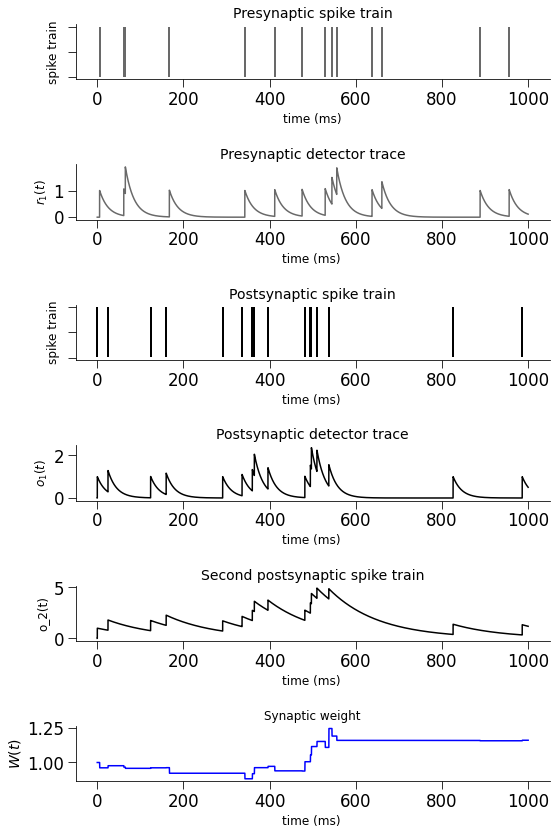

In [9]:
# Define the STDP rule parameters
A_plus = 0.05       # maximum amount of potentiation (LTP)
A_minus = 0.05      # maximum amount of potentiation (LTD)
tau_plus = 20e-3  # LTP time constant [s]
tau_minus = 20e-3 # LTD time constant [s]
tau_y = 114e-3    # second LTP time constant [s]
discretization_step=1e-4 # discretization time step [s]
t_range=np.arange(0,1,discretization_step)     # time interval [s]

# Generate a presynaptic spike train
pre_spike = Poisson_spike_train(discretization_step, t_range, rate=15, myseed=7)
# Generate a postsynaptic spike train
post_spike = Poisson_spike_train(discretization_step, t_range, rate=15, myseed=1)
# Initialize the synaptic weight
w0 = 1
# Keep track of the pre- and postsynaptic detector traces and the synaptic weight over time 
r1,o1,o2,w = detectors_tripSTDP(t_range,pre_spike,post_spike,A_plus,A_minus,tau_plus,tau_minus,tau_y,discretization_step,w0)
# Plotting
trip_track_plot(t_range,pre_spike,r1,post_spike,o1,o2,w)

## 5. Pairing protocol analysis: matching the data

The classical STDP protocol consist of eliciting pairs of presynaptic and postsynaptic spikes at a given frequency $\rho$, so the time distance between two consecutive pairs is $1/\rho$, whereas the pre- and postsynaptic spikes are shifted by a fixed time $\Delta t < 1/\rho $. We study the weight change as a function of the frequency $\rho$ for a fixed $\Delta t$.

In our case, 60 pairs of spikes shifted by either $\Delta t = 10 $ ms (therefore a postsynaptic spike **follows** a presynaptic spike after 10 ms) or $\Delta t = - 10 $ ms (therefore a postsynaptic spike **is followed by** a presynaptic spike after 10 ms) are elicited at regular intervals of 1/$\rho$, for $\rho \in [0.1,50]$ Hz. 

We calculate the synaptic change with both the pair-based and the triplet STDP functions as described in the previous sections of this tutorial, and we compare our results with the experimental data from [Sjöström et al, Neuron (2021)](https://doi.org/10.1016/s0896-6273(01)00542-6) 

The data is represented below.  You can see the change in synaptic weight $\Delta w$ as a function of the frequency $\rho$, for the two shift in spike-time mentioned above. 


<img src="https://github.com/comp-neural-circuits/plasticity-workshop/raw/dev/pairing_data.png" alt="experimental data" style="width:500px;"/>

#### Helper function

The following function generates two spike trains (one pre- and one postsynaptic spike train) where neurons fire at the same, fixed time interval. There is however a shift in spike times, so that presynaptic firing either follows or precedes postsynaptic firing.  

Before you move on, please take a look at the function.

In [10]:
def firstspike_secondspike(discretization_step, rho, num_pairs):
    """
    Generates presynaptic and postsynaptic spike trains characterised by a number of pairs 
    (given by `num_pairs`) of pre- and post-synaptic spikes with time distance `DeltaT`.
    The pairs are repeated at frequency `rho` 

    1) Generate two "small" arrays containing only one pair of one pre- and one post-synaptic spikes
    within a time window 1/rho. These will be the "building blocks" of the full spike trains.

    2) Construct the full spike trains by repeating the small arrays the number of times given by num_pairs.
    
    Parameters:
    discretization_step (number) :  :-S    HELP ! 
    rho (number) : the frequency in Hz at which the pairs appear
    num_pairs    : the total number of pairs  ( so this is frequency * total_time_duration) ? Claudia fix this!
    
    Returns:
    spiketrain_1 (1D numpy array) : binary array with the first spiketrain (one element is a 1ms bin)
    spiketrain_2 (1D numpy array) : binary array with the second spiketrain
    """
    
    DeltaT = discretization_step*100   # time distance between pre- and postsynaptic spikes. It must be greater than the discretization_step!
    pair_distance = round(1/rho,2)   # time distance between pairs of pre-post spikes.

    # Generate the first piece of the pre- and postsynaptic spike trains (namely, one pair of pre- and post-synaptic spikes) within a time window 1/rho 
    small_t_range = np.arange(0,pair_distance - discretization_step,discretization_step)   # time interval between pairs of pre-post spikes.
    t_range=np.arange(0,num_pairs*(pair_distance - discretization_step),discretization_step)            # the whole time interval 

    first_spike = np.zeros(len(small_t_range))           # initialize the first piece of the pre-synaptic spike train 
    second_spike = np.zeros(len(small_t_range))          # initialize the first piece of the post-synaptic spike train
    first_spike[0] = 1                                   # generate a pre-syn spike at time 0 
    second_spike[np.where(small_t_range==DeltaT)[0]] = 1 # generate a post-syn spike after DeltaT
    first_spikes=np.tile(first_spike,num_pairs)          # repeat for 'num_pairs' times and create the full spike train
    second_spikes=np.tile(second_spike,num_pairs)        # repeat for 'num_pairs' times and create the full spike train
    return first_spikes, second_spikes, t_range

In [11]:
def firstspike_secondspike_update(rho,time_total,DeltaT,discretization_step=1E-4):
    """
    Generates presynaptic and postsynaptic spike trains characterised by a number of pairs 
    of pre- and post-synaptic spikes with time distance `DeltaT`.
    The pairs are repeated at frequency `rho` 
    
    Parameters:
    rho (number) : the firing frequency in Hz of each neuron
    time_total (number) : the duration of the spike trains, in seconds
    DeltaT (number) : the time distance between pre and post spike, in seconds  
    discretization_step = 1E-4    : a very small time interval (in seconds), express the spike trains as binary. 
                                     The default is to consider time-bins of 0.1 ms.                        
    
    Returns:
    times  (1D numpy array) : times associated to binary spiketrain (in seconds)
    spiketrain_pre (1D numpy array) : binary array with the first spiketrain (one element is a bin of size `discretization_step`)
    spiketrain_post (1D numpy array) : binary array with the second spiketrain
    """
    
    assert DeltaT < (1/rho) , "interval between spikes is too large compared to frequency !"
    
    # time vector
    times = np.arange(0.0,time_total,discretization_step)
    
    # spike times, with frequency rho
    train1_s = np.arange(0.0,time_total,1/rho) 
    train2_s = train1_s + abs(DeltaT) # second neuron fires with DetlaT offset 
    
    # spike times in discretized units, converted to integer
    train1_discr = (train1_s * (1/discretization_step)).astype(np.int64) 
    train2_discr = (train2_s * (1/discretization_step)).astype(np.int64)
    
    # build the binary spike trains, using discretized spike times
    train1_bin = np.zeros(len(times))
    train1_bin[train1_discr] = 1
    train2_bin = np.zeros(len(times))
    train2_bin[train2_discr] = 1
    # sign of DeltaT determines which spikes first
    if DeltaT > 0:
        # pre spike before, post spike later
        return times,train1_bin,train2_bin
    else:
        # post spike before, pre spike later
        return times,train2_bin,train1_bin

#### Coding exercise 5: pairing protocol with the pairwise STDP rule

Let's begin with the pairing protocol analysis via the pairwise STDP rule. In the next exercise, you will choose the order of spikes in the pre- and postsynaptic neurons by exploiting the *helper function* above, and you will calculate the synaptic change (the difference between the final weight and the initial weight) for each frequency value provided by the vector *rho_vec*. 

There are two different for loops in the code, in order to account for both the *pre-post* and the *post-pre* cases.

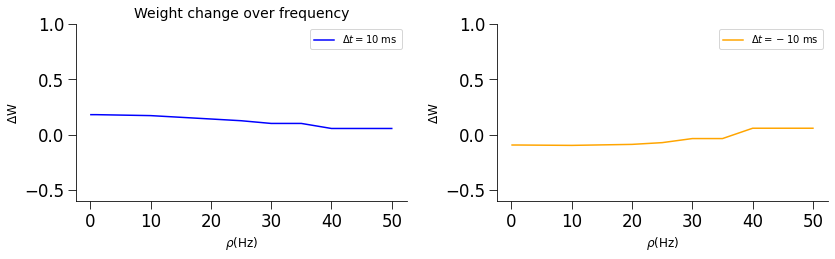

In [12]:
# Initialization 
num_pairs = 60             # number of pre- and postsyn spike pairs 
rho_vec = np.array([0.1, 1, 10, 20, 25, 30, 35, 40, 50])        # frequency values [Hz]
discretization_step = 1e-4 # (s)
tau_plus = 16.8e-3            # LTP time constant (s)
tau_minus = 33.7e-3           # LTD time constant (s)
A_plus = 5.6e-3            # LTP window amplitude
A_minus = 2.1e-3           # LTD window amplitude
w0 = 1                     # initial weight

# initialize the synaptic change
DeltaW = np.zeros(len(rho_vec))        # for pre-post (Delta_t >0)
DeltaW_rev = np.zeros(len(rho_vec))    # for post-pre (Delta_t <0)

# Calculate the synaptic change for every frequency value
for ind,rho in enumerate(rho_vec):
    # if Delta_t > 0 
    pre_spike, post_spike, t_range = firstspike_secondspike(discretization_step, rho, num_pairs)
    # 
    r1,o1,w = detectors_pairSTDP(t_range,pre_spike,post_spike,A_plus,A_minus,tau_plus,tau_minus,discretization_step,w0)
    # Calculate the weight change as a function of the given frequency rho
    DeltaW[ind]= w[-1]-w[0]
    
# Calculate the synaptic change for every frequency value
for ind,rho in enumerate(rho_vec):
    # if Delta_t < 0 
    # The case with DeltaT < 0 is equivalent to switch the pre- and the postsynaptic spike trains.
    post_spike, pre_spike, t_range = firstspike_secondspike(discretization_step, rho, num_pairs)
    r1,o1,w = detectors_pairSTDP(t_range,pre_spike,post_spike,A_plus,A_minus,tau_plus,tau_minus,discretization_step,w0)
    # Calculate the weight change as a function of the given frequency rho
    DeltaW_rev[ind]= w[-1]-w[0]
    
# Plotting
plot_over_frequency(rho_vec,DeltaW,DeltaW_rev)


**Thinking break:** 

Experiments show that potentiation increases when frequency increases. Why do you think this behavior can not be reproduced by pairwise STDP model? Indeed, in pair-based STDP models, as soon as the frequency increases, the pre-post pairs approach each other and generate an interaction between the postsynaptic spike of one pair and the presynaptic spike of the next pair. The effect of these post-pre pairs should increase with frequency and therefore depress the synapse, which is not what is seen in the experiments. 

#### Coding exercise 6: pairing protocol with the triplet STDP rule

The pair-based STDP rule fails to reproduce frequency effects of the pairing protocol. This is mainly because of the fact that pair-based model are intrinsically symmetric, in the sense that they predict the same weight change for a pre-post pair followed by a post-pre pair with the same delay $\Delta t$ as for the inverted order i.e., a post-pre pair followed by a pre-post pair (with the same delay $\Delta$t)] (*Pfister and Gerstner, 2006*). However, there is no a priori reason to think that a pre-post-pre and a post-pre-post triplet should give the same result because they will activate different presynaptic and postsynaptic pathways.
How to break the symmetry induced by pair-based model? That's right, with the triplet STDP rule! So, let's turn to the triplet STDP rule and let's see what happens.

The following code is completely analogous to the one provided for the pair-based STDP rule. Your task here will be to run it and think about the results.

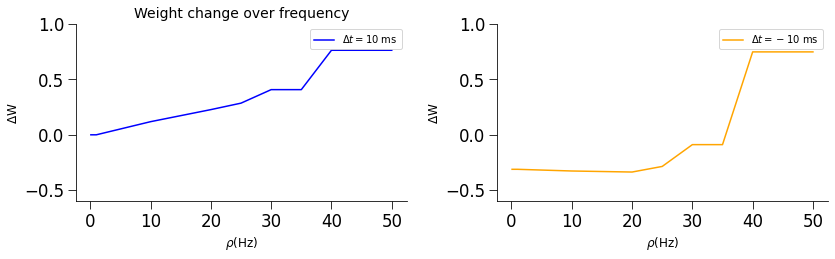

In [16]:
# Initialization 
num_pairs = 60             # number of pre- and postsyn spike pairs 
rho_vec = np.array([0.1, 1, 10, 20, 25, 30, 35, 40, 50])        # frequency values [Hz]
discretization_step = 1e-4 # (ms)
tau_plus = 16.8e-3            # LTP time constant (s)
tau_minus = 33.7e-3           # LTD time constant (s)
tau_y = 114e-3             # Second LTP time constant (s)
A_plus = 6.5e-3             # LTP window amplitude
A_minus = 7.1e-3            # LTD window amplitude
w0 = 1                     # initial weight

# initialize the synaptic change
DeltaW = np.zeros(len(rho_vec))    
DeltaW_rev = np.zeros(len(rho_vec))    # for post-pre (Delta_t <0)

for ind,rho in enumerate(rho_vec):
    # if Delta_t > 0 
    pre_spike, post_spike, t_range = firstspike_secondspike(discretization_step, rho, num_pairs)
    # Calculate the weight change
    r1,o1,o2,w = detectors_tripSTDP(t_range,pre_spike,post_spike,A_plus,A_minus,tau_plus,tau_minus,tau_y,discretization_step,w0)
    # Calculate the weight change as a function of the frequency
    DeltaW[ind]= w[-1]-w[0]
    
for ind,rho in enumerate(rho_vec):
    # if Delta_t < 0 
    # The case with DeltaT < 0 is equivalent to switch the pre- and the postsynaptic spike trains.
    post_spike, pre_spike, t_range = firstspike_secondspike(discretization_step, rho, num_pairs)
    # Calculate the weight change
    r1,o1,o2,w = detectors_tripSTDP(t_range,pre_spike,post_spike,A_plus,A_minus,tau_plus,tau_minus,tau_y,discretization_step,w0)
    # Calculate the weight change as a function of the frequency
    DeltaW_rev[ind]= w[-1]-w[0]
    
# Plotting
plot_over_frequency(rho_vec,DeltaW,DeltaW_rev)

## 6. Inhibitory plasticity

#### Coding exercise 7: the inhibitory STDP function 

In [14]:
def DeltaW_inhSTDP(eta, rho, tau):
    """    
    

    Parameters: 
    eta : 
    rho: 
    tau: 
    
    Returns 
    DeltaW(1D- array) : the instantaneous weight change due to the inhibitory STDP rule
    """
    # Define the array with the time differences between post- and pre-synaptic spikes
    Delta_t = np.linspace(-200, 200, 100)
    # Initialize the STDP change
    DeltaW = np.zeros(len(Delta_t))
    # Calculate DeltaW
    DeltaW = eta * ( (1/(2*tau)) * np.exp(-np.abs(Delta_t)/tau) - rho)
    DeltaW = 100*DeltaW/np.max(DeltaW)

    return Delta_t, DeltaW
interact(inhSTDP_plot, eta = fixed(1e-4), rho = fixed(3e-3), tau = (10,70,0.1));

interactive(children=(FloatSlider(value=40.0, description='tau', max=70.0, min=10.0), Output()), _dom_classes=…

**TO DO** Temporal evolution of the postsynaptic firing rate and the average synaptic weights of the inhibitory synapses

 Total excitatory, inhibitory, and net (green) membrane currents before, during, and after inhibitory synaptic plasticity.

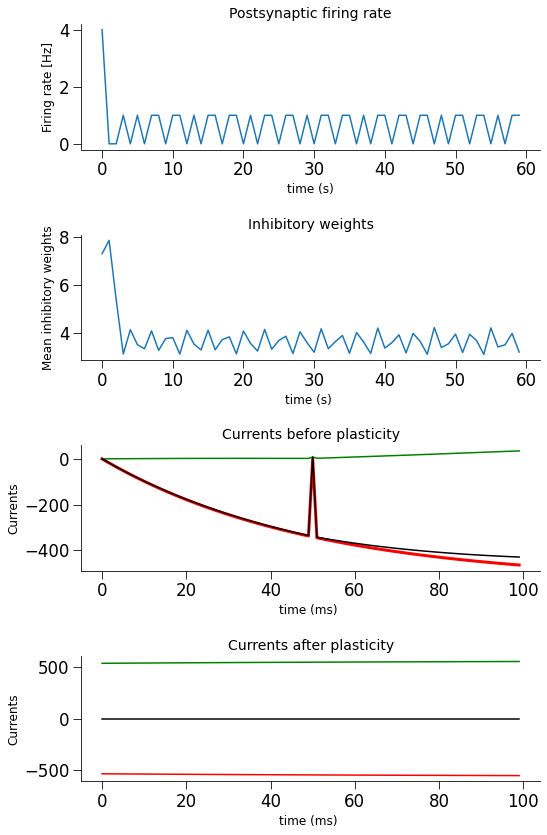

In [15]:
dt = 0.1
duration=1000 # duration of a small interval in ms  
num_small_intervals=60
range_t=np.arange(0,num_small_intervals*duration,dt)            # the whole time interval 
rate = 60
n = 100
exc = int(0.8 * n)
tauExc = 5
tauInh = 10
tauPlasticity = 20
gBarExc = 0.14
gBarInh = 0.35
VRest=-60
Vth=-50
taumem=20
EGABA=-80
eta = 0.01
alpha = 0.25 * eta
tRef = 5

W=np.zeros(n)
np.random.seed(7)
W[0:exc] =  (1.1 + np.random.random(exc))
W[exc:n] = 0.1

input_spiketrains = np.zeros((n, len(range_t)))
for s in range(n):
    input_spiketrains[s,:] = Poisson_spike_train(dt, range_t, rate, s)
post_spike_count = 0
post_rate = 0
post_spike = np.zeros(len(range_t))

gExc = 0
gInh = 0
gLeak = 1
r1 = np.zeros(n)
o1 = 0
save_inh_weights = np.zeros(len(range_t))
tolos = 0 

V = np.zeros(len(range_t))
Exkeep= np.zeros(len(range_t))
Inkeep = np.zeros(len(range_t))
V[0]=VRest

for ind,t in enumerate(range_t):
    if ind == 0:
        continue
    gExc = gExc - dt/tauExc * gExc 
    gInh = gInh - dt/tauInh * gInh

    for s in range(exc,n):
        r1[s] = r1[s] - dt/tauPlasticity * r1[s]
    o1 = o1 - dt/tauPlasticity * o1

    for s in range(exc):
        if input_spiketrains[s, ind] == 1:
            gExc += (gBarExc * W[s])
    for s in range(exc,n):
        if input_spiketrains[s, ind] == 1:
            gInh = gInh + (gBarInh * W[s])    
            r1[s] += eta                    
            W[s] = W[s] + o1 - alpha                # plasticity
            if W[s] < 0:
                W[s] = 0 
    # postsynaptic neuron 
    if ((t - tolos) < tRef):
        V[ind] = VRest
    else:
        gTot = gLeak + gExc + gInh
        tauEff = taumem/gTot  
        VInf = ((gLeak*VRest + gInh*EGABA)/gTot)
        V[ind] = VInf + (V[ind-1] - VInf)*np.exp(-dt/tauEff)
    if V[ind] >= Vth:
        tolos = t
        V[ind] = 0
        V[ind-1] = VRest
        o1 += eta
        post_spike_count += 1
        post_spike[ind] = 1
        for s in range(exc,n):
            W[s] += r1[s]   # plasticity
    Exkeep[ind] = gExc * V[ind]
    Inkeep[ind] = gInh * (V[ind] - EGABA)
    save_inh_weights[ind] = np.mean(W[exc:n])
    
inh_analysis_plot(num_small_intervals,post_spike,save_inh_weights, duration,Exkeep,Inkeep)